## Inference using Ensemble Method


In [23]:
from transformers import BertForSequenceClassification
from pathlib import Path
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
import evaluate
from transformers import (
    AutoTokenizer,
    GPT2LMHeadModel,
    AutoConfig,
    AutoModelForSequenceClassification,
)
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import glob
import pickle
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from utils import *
import numpy as np
import seaborn as sns

In [2]:
torch.cuda.empty_cache()

## Configuration files


In [3]:
data_path = Path("filler")
seed = 42

# Tokenizer
tokenizer_path = data_path / "tokenizer/tokenizer.json"

# Classifier Finetuning
classifier_output_model_path = data_path / "finetune_lm"

## Load model and tokenizer


In [4]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path.parent)
config = AutoConfig.from_pretrained(classifier_output_model_path / "epoch_7")
config.num_labels = 2
tokenizer.pad_token = "<pad>"
config.pad_token_id = tokenizer.pad_token_id
tokenizer.model_max_length = config.n_positions

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    classifier_output_model_path / "epoch_7"
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.pad_token_id = tokenizer.pad_token_id
model.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(30001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

## Ensemble Method


In [6]:
L = 16


def run_ensemble_method(page):
    # classify any page with < 32 features as filler
    if page.shape[1] < 32:
        return float(1.0)

    ints = convert_binary_to_int(page)
    line = " ".join([str(i) for i in ints])
    chars = convert_line_to_char_sequence(line)
    chars = chars.split(" ")

    frags = []
    for i in range(0, len(chars) - L, L // 2):
        frags.append(" ".join(chars[i : i + L]))

    input = tokenizer(frags, return_tensors="pt", padding=True).to(device)
    preds = model(**input)
    logits = preds.logits
    probability = torch.softmax(logits, dim=1)
    return float(torch.mean(probability, 0)[1])

## Run on page level


In [7]:
train_pages, val_pages, train_filler_pages, val_filler_pages = pd.read_pickle(
    data_path / "train_val_page_split.pkl"
)
print(f"{sum([len(train_pages[d]) for d in train_pages])} pages in train_pages")
print(f"{sum([len(val_pages[d]) for d in val_pages])} pages in val_pages")
print(
    f"{sum([len(train_filler_pages[d]) for d in train_filler_pages])} pages in train_filler_pages"
)
print(
    f"{sum([len(val_filler_pages[d]) for d in val_filler_pages])} pages in val_filler_pages"
)

3478 pages in train_pages
2460 pages in val_pages
160 pages in train_filler_pages
99 pages in val_filler_pages


In [8]:
val_nonfiller = [
    page for dir in val_pages for page in val_pages[dir] if page is not None
]
val_filler = [
    page
    for dir in val_filler_pages
    for page in val_filler_pages[dir]
    if page is not None
]
train_nonfiller = [
    page for dir in train_pages for page in train_pages[dir] if page is not None
]
train_filler = [
    page
    for dir in train_filler_pages
    for page in train_filler_pages[dir]
    if page is not None
]

In [9]:
val_nonfiller_probs = []
for i in range(len(val_nonfiller)):
    if i and i % 250 == 0:
        print(f"Processing page: {i}")
    val_nonfiller_probs.append(
        (run_ensemble_method(val_nonfiller[i][0]), val_nonfiller[i][1])
    )

Processing page: 250
Processing page: 500
Processing page: 750
Processing page: 1000
Processing page: 1250
Processing page: 1500
Processing page: 1750
Processing page: 2000
Processing page: 2250


In [10]:
val_filler_probs = []
for i in range(len(val_filler)):
    if i and i % 25 == 0:
        print(f"Processing page: {i}")
    val_filler_probs.append((run_ensemble_method(val_filler[i][0]), val_filler[i][1]))

Processing page: 25
Processing page: 50
Processing page: 75


In [11]:
train_nonfiller_probs = []
for i in range(len(train_nonfiller)):
    if i and i % 250 == 0:
        print(f"Processing page: {i}")
    train_nonfiller_probs.append(
        (run_ensemble_method(train_nonfiller[i][0]), train_nonfiller[i][1])
    )

Processing page: 250
Processing page: 500
Processing page: 750
Processing page: 1000
Processing page: 1250
Processing page: 1500
Processing page: 1750
Processing page: 2000
Processing page: 2250
Processing page: 2500
Processing page: 2750
Processing page: 3000
Processing page: 3250


In [12]:
train_filler_probs = []
for i in range(len(train_filler)):
    if i and i % 25 == 0:
        print(f"Processing page: {i}")
    train_filler_probs.append(
        (run_ensemble_method(train_filler[i][0]), train_filler[i][1])
    )

Processing page: 25
Processing page: 50
Processing page: 75
Processing page: 100
Processing page: 125
Processing page: 150


In [13]:
all_val_probs = val_nonfiller_probs + val_filler_probs
val_probability = [x[0] for x in all_val_probs]
val_page = [x[1] for x in all_val_probs]
val_label = [float(0)] * len(val_nonfiller) + [float(1)] * len(val_filler)

results = pd.DataFrame(
    {"label": val_label, "probability": val_probability, "page": val_page}
)
results.to_csv(data_path / "validation_page_ensemble.csv", index=False)

In [14]:
all_train_probs = train_nonfiller_probs + train_filler_probs
train_probability = [x[0] for x in all_train_probs]
train_page = [x[1] for x in all_train_probs]
train_label = [float(0)] * len(train_nonfiller) + [float(1)] * len(train_filler)

results = pd.DataFrame(
    {"label": train_label, "probability": train_probability, "page": train_page}
)
results.to_csv(data_path / "train_page_ensemble.csv", index=False)

## Performance Metrics


In [15]:
df = pd.read_csv(data_path / "validation_page_ensemble.csv")
label = df["label"]
probability = df["probability"]
page = df["page"]

### Confusion Matrix


In [17]:
threshold = 0.5
predicted_labels = (
    df["probability"].apply(lambda x: 1.0 if x >= threshold else 0.0).tolist()
)
true_labels = df["label"].tolist()
cm = confusion_matrix(true_labels, predicted_labels)
pd.DataFrame(
    cm,
    index=["Actual Non-Filler", "Actual Filler"],
    columns=["Predicted Non-Filler", "Predicted Filler"],
)

,Predicted Non-Filler,Predicted Filler
Actual Non-Filler,2443,17
Actual Filler,2,97


### ROC Curve


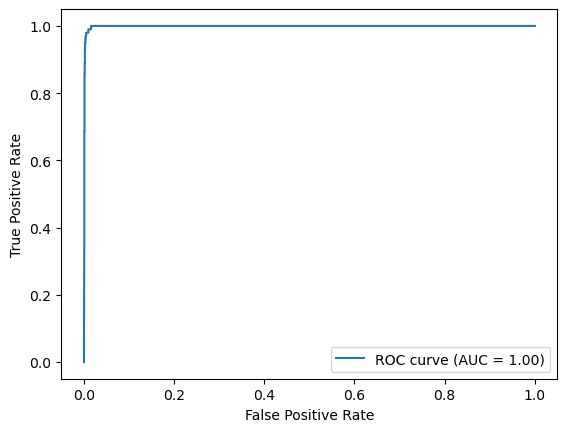

In [18]:
fpr, tpr, thresholds = roc_curve(y_true=label, y_score=probability)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [32]:
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 = {f1}")

Precision = 0.8508771929824561
Recall = 0.9797979797979798
F1 = 0.9107981220657276


### Distributions


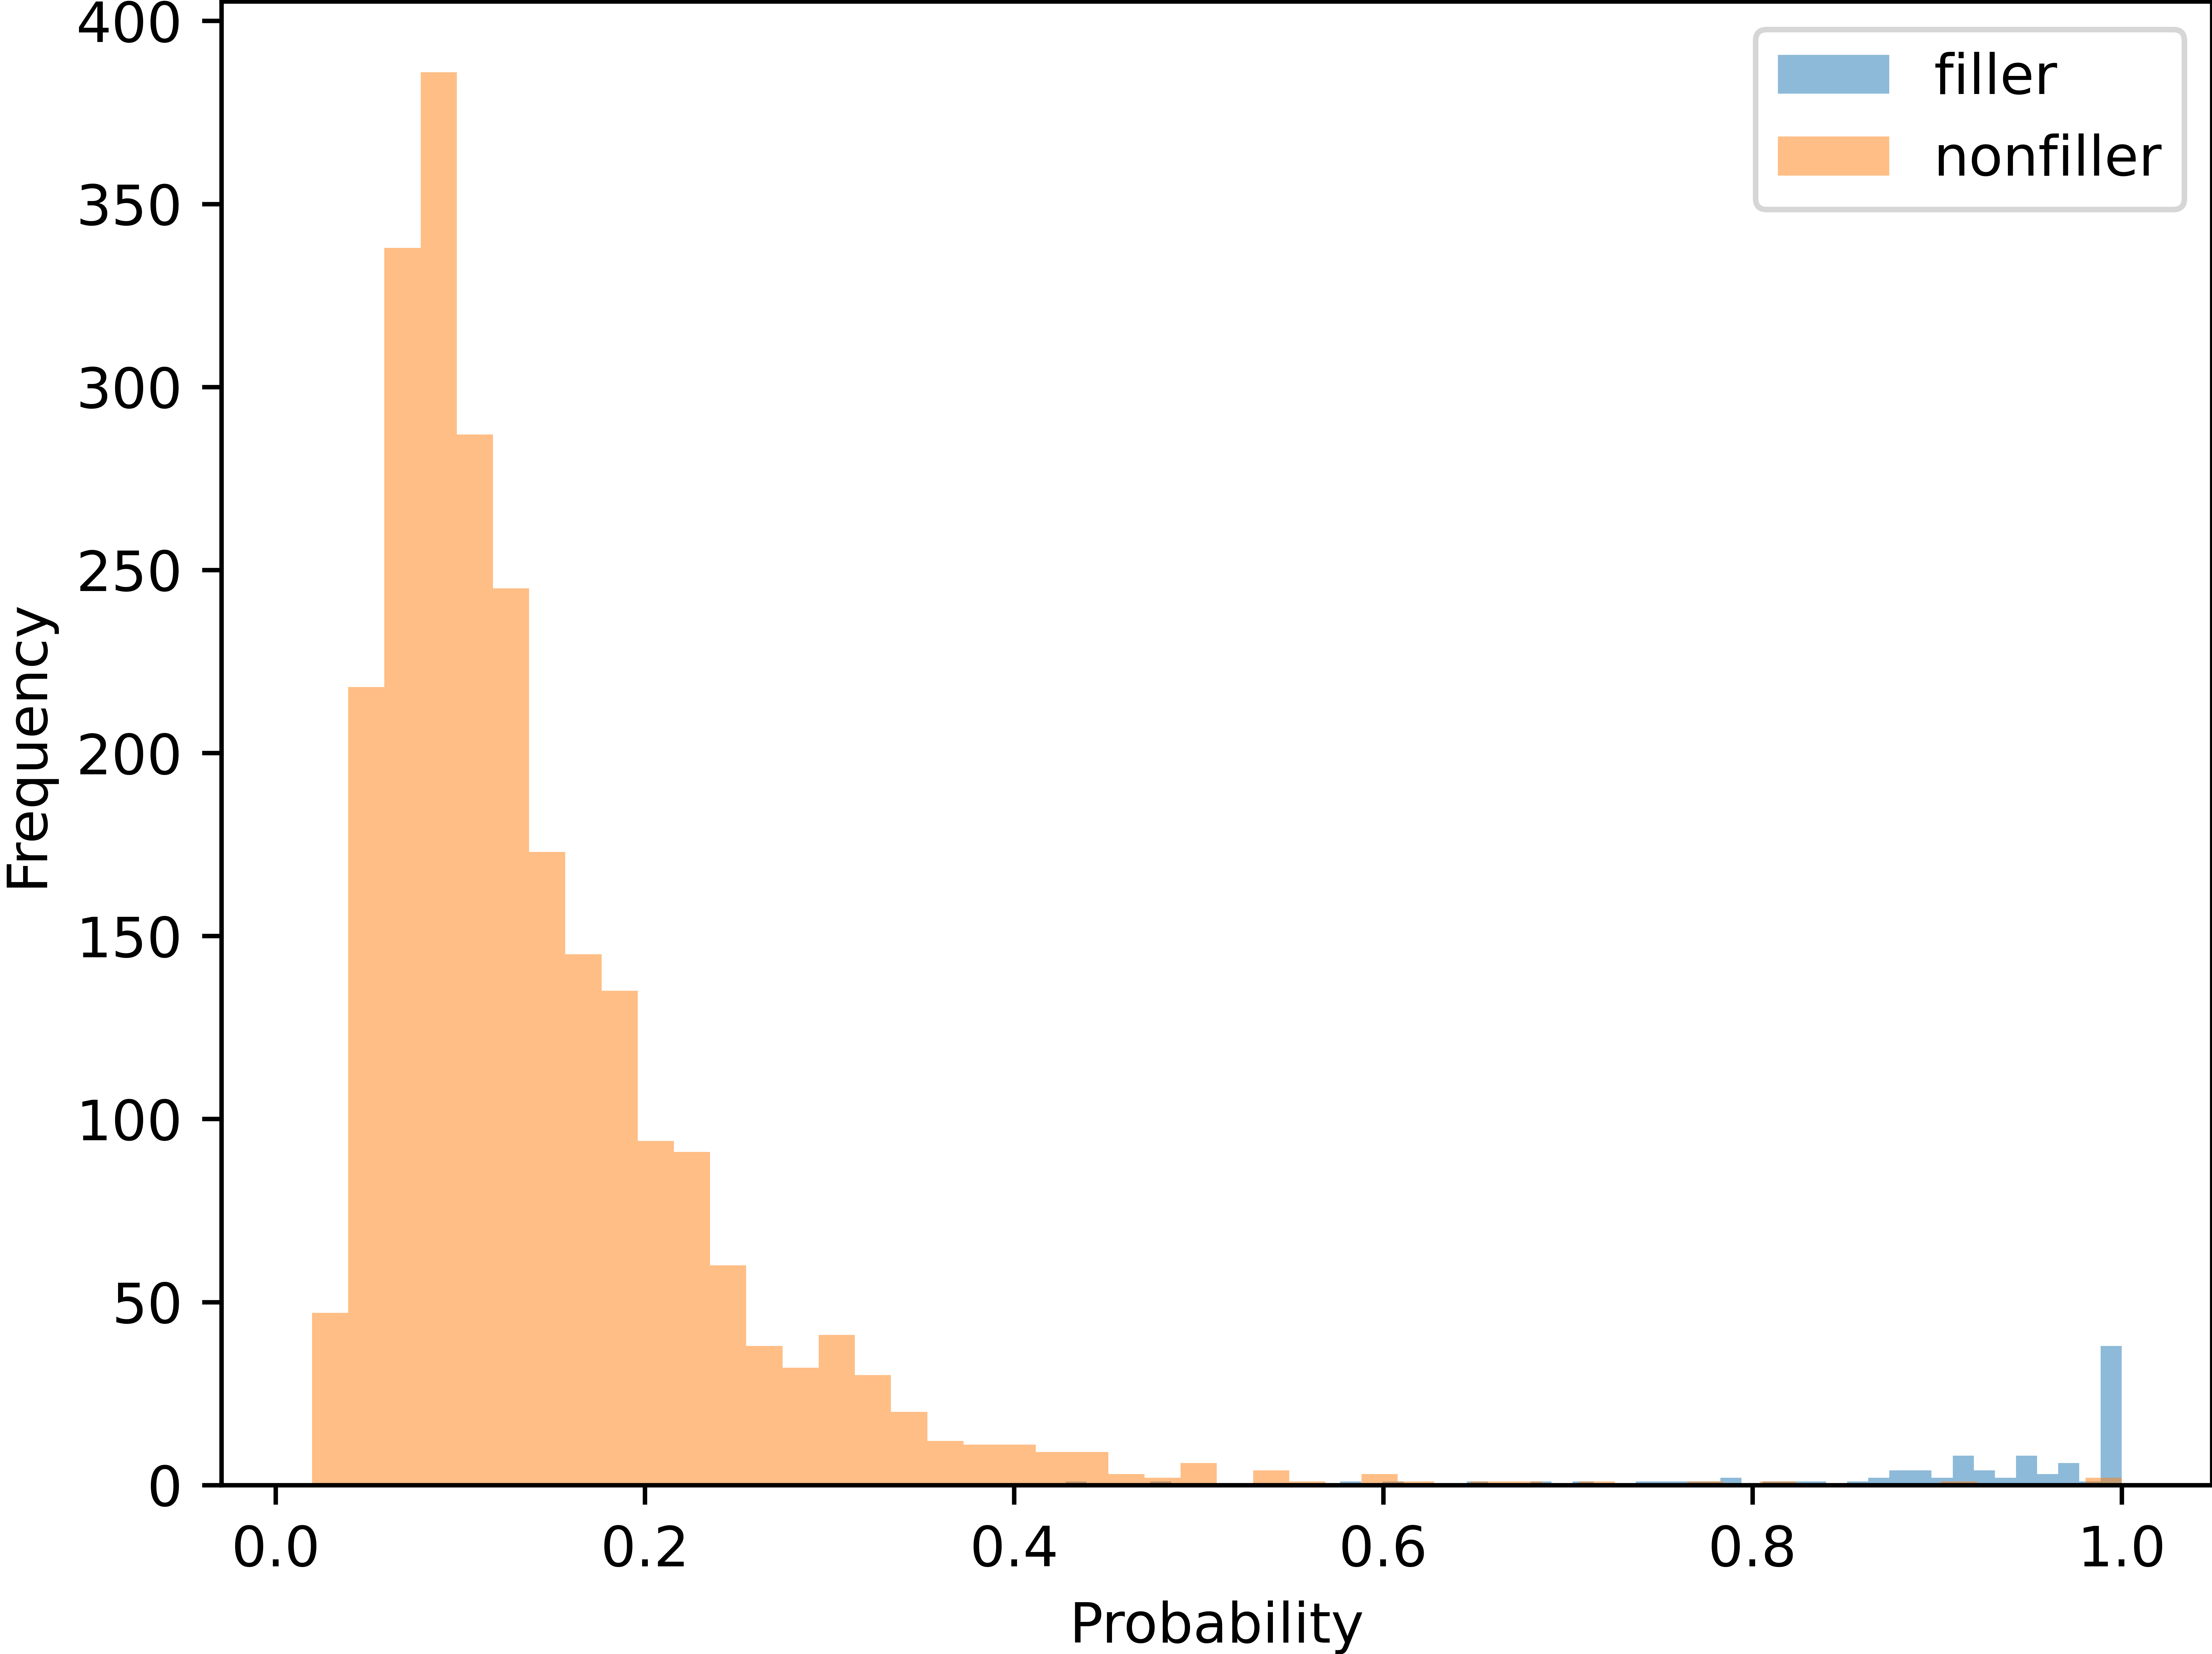

<Figure size 640x480 with 0 Axes>

In [29]:
plt.figure(dpi=1200)
mpl.rcParams["savefig.pad_inches"] = 0
df.loc[df.label == 1.0].probability.plot(
    kind="hist", alpha=0.5, bins=50, label="filler"
)
df.loc[df.label == 0.0].probability.plot(
    kind="hist", alpha=0.5, bins=50, label="nonfiller"
)
plt.xlabel("Probability")
plt.legend()
plt.show()
plt.savefig("figures/ensemble-distribution.png")

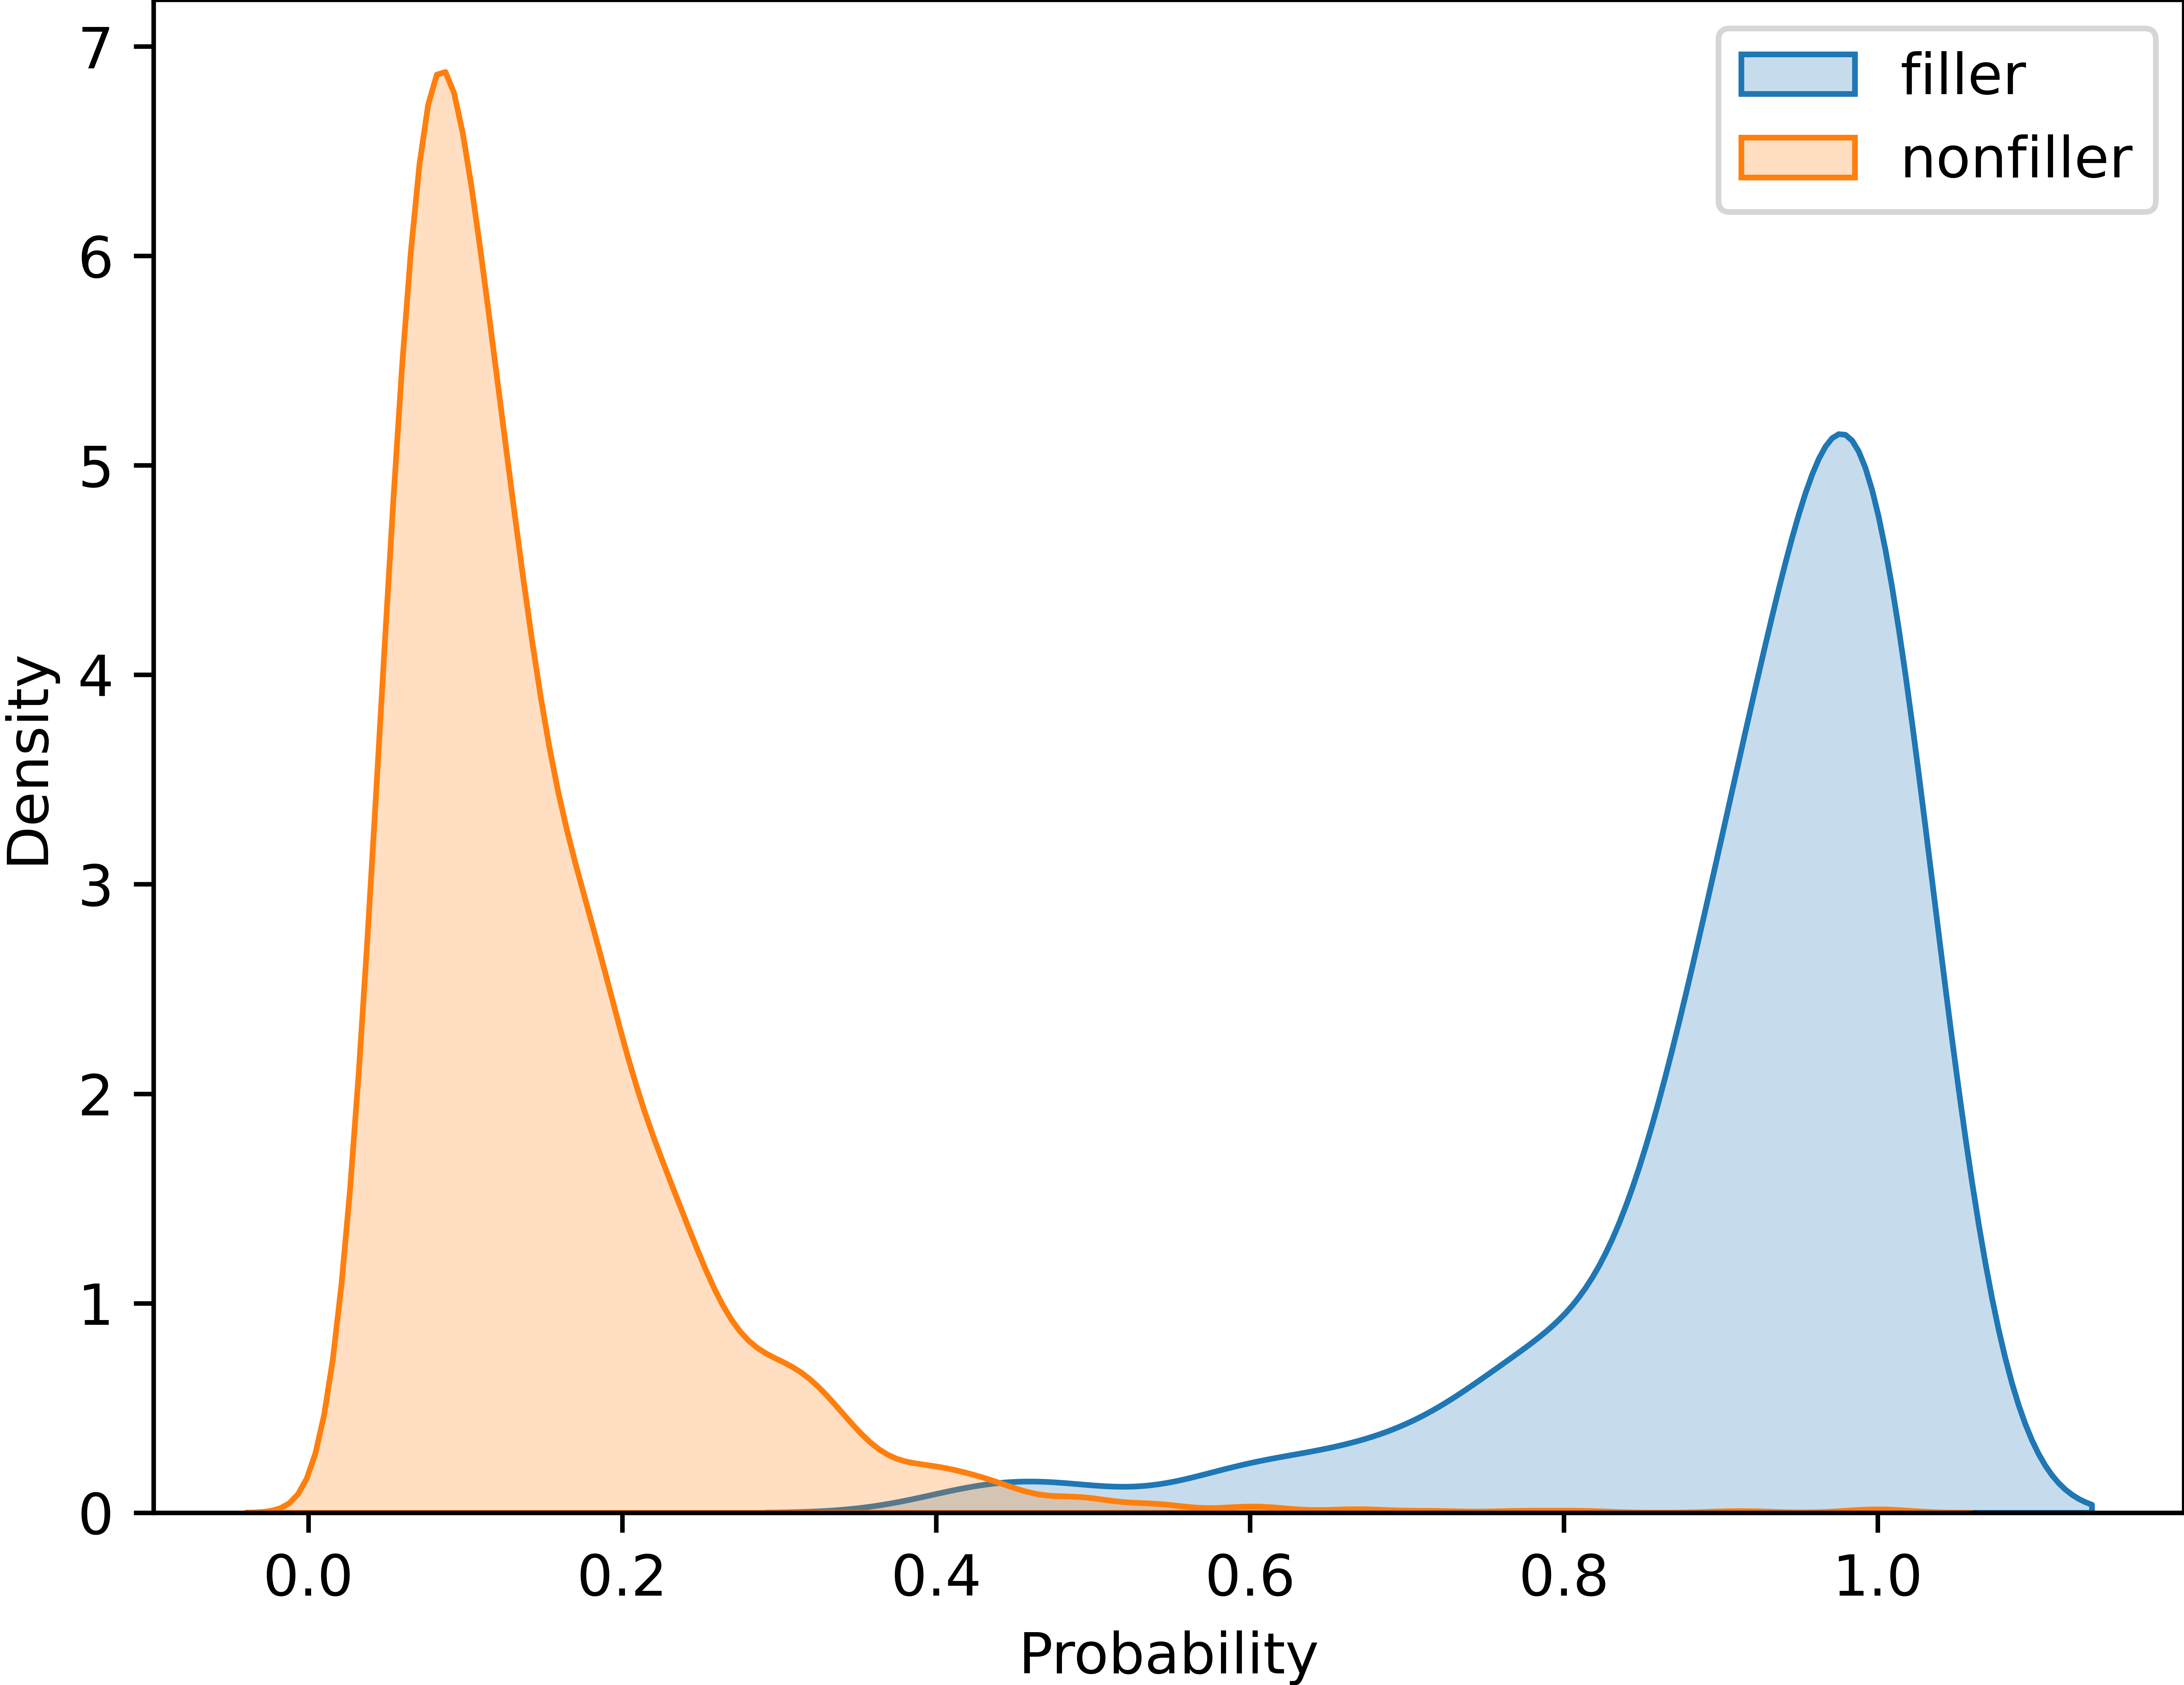

In [31]:
plt.figure(dpi=1200)
sns.kdeplot(data=df.loc[df.label == 1.0, "probability"], label="filler", fill=True)
sns.kdeplot(data=df.loc[df.label == 0.0, "probability"], label="nonfiller", fill=True)
plt.xlabel("Probability")
plt.legend()
plt.show()

In [32]:
desired_tpr = 0.95
index = np.abs(tpr - desired_tpr).argmin()
print(
    f"Desired threshold is {thresholds[index]} to give TPR {desired_tpr} and FPR {fpr[index]}"
)

Desired threshold is 0.6879814267158508 to give TPR 0.95 and FPR 0.0024390243902439024


## Let's examine the edge cases


In [33]:
lowest_filler = df[df["label"] == 1.0].sort_values("probability")[:20]
lowest_filler

,label,probability,page
2508,1.0,0.427933,Scriabin/75863/6
2548,1.0,0.483678,Liszt/286008/2
2512,1.0,0.582427,Chopin/447364/0
2510,1.0,0.609567,Liszt/491854/0
2483,1.0,0.654507,Beethoven/377818/1
2556,1.0,0.687981,Liszt/115105/0
2464,1.0,0.703097,Schumann/456369/1
2530,1.0,0.741114,Scriabin/517181/6
2557,1.0,0.757224,Scriabin/508537/0
2476,1.0,0.769788,Liszt/331506/17


In [34]:
highest_nonfiller = df[df["label"] == 0.0].sort_values("probability")[-20:]
highest_nonfiller

,label,probability,page
361,0.0,0.497729,Liszt/04460/9
1153,0.0,0.498028,Liszt/117306/11
353,0.0,0.498481,Liszt/04460/1
1894,0.0,0.532136,Scriabin/507376/8
1896,0.0,0.534476,Scriabin/507376/10
1846,0.0,0.535443,Scriabin/508550/4
1919,0.0,0.544287,Schumann/78923/11
1054,0.0,0.550917,Liszt/516478/56
1467,0.0,0.591286,Scriabin/509050/11
1035,0.0,0.599302,Liszt/516478/35
